In [32]:
import catboost
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns

In [33]:
from sklearn.datasets import load_wine

data = load_wine(as_frame=True)
wine = data.data

In [34]:
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(wine, data.target, train_size=0.8, random_state=1)

# 1. CatBoostClassifier
## Применить классификатор

In [36]:
from catboost import CatBoostClassifier
from catboost import Pool

model = CatBoostClassifier()
model.fit(X_train, y_train, eval_set=(X_test,y_test), silent=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Вывод наилучшей итерации и Logloss соответственно 

In [37]:
model.best_iteration_, model.best_score_

(255,
 {'learn': {'MultiClass': 0.0026968883024149817},
  'validation': {'MultiClass': 0.07565172479633399}})

## Метрики качетва классификации на тестовых данных

In [38]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,confusion_matrix;
def MdMetrics(predictions, y_test):
    print("Accuracy: ",accuracy_score(np.array(y_test),predictions));
    print("Precision: ",precision_score(np.array(y_test),predictions, average = 'macro',zero_division=0))
    print("Recall: ", recall_score(np.array(y_test), predictions,average = 'macro'))
    print("F1: ", f1_score(np.array(y_test), predictions,average = 'macro'))
    sns.heatmap(confusion_matrix(np.array(y_test),predictions),cmap = 'viridis', annot=True)

Accuracy:  0.9722222222222222
Precision:  0.9777777777777779
Recall:  0.9743589743589745
F1:  0.9751724137931035


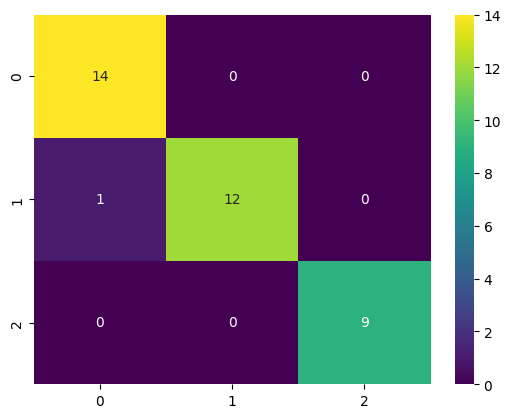

In [39]:
MdMetrics(model.predict(X_test),y_test)

# 2. CatBoostRegressor

In [40]:
from catboost import CatBoostRegressor
from sklearn.datasets import load_digits

data = load_digits(as_frame=True)
digits = data.data
digits_target = data.target

X_train, X_validation, y_train, y_validation = train_test_split(digits, digits_target, train_size=0.8, random_state=1)

model = CatBoostRegressor(custom_metric=['MAE'])
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True 
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [41]:
model.best_iteration_, model.best_score_

(996,
 {'learn': {'MAE': 0.08675023210620876, 'RMSE': 0.11307620176941803},
  'validation': {'MAE': 0.5421333681155415, 'RMSE': 0.8060944394303748}})

# 3. Бинарная классификация и метрики PRC ROC

In [42]:
from catboost import cv
from sklearn.datasets import load_breast_cancer

bin_data = load_breast_cancer(as_frame=True)
bin_pool = Pool(bin_data.data, label=bin_data.target)

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = bin_pool,
    fold_count=5,
    type = 'Classical',
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.107315198
bestIteration = 10

Training on fold [1/5]

bestTest = 0.03303576548
bestIteration = 21

Training on fold [2/5]

bestTest = 0.1249562628
bestIteration = 9

Training on fold [3/5]

bestTest = 0.06653401197
bestIteration = 62

Training on fold [4/5]

bestTest = 0.108185942
bestIteration = 60



In [43]:
X_train, X_validation, y_train, y_validation = train_test_split(bin_data.data, bin_data.target, train_size=0.8, random_state=1)

model = CatBoostClassifier()
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)
model_metrics = model.eval_metrics(data=bin_pool, metrics=['Precision','Recall','AUC','PRAUC'], ntree_start=0, ntree_end=0, eval_period=1, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

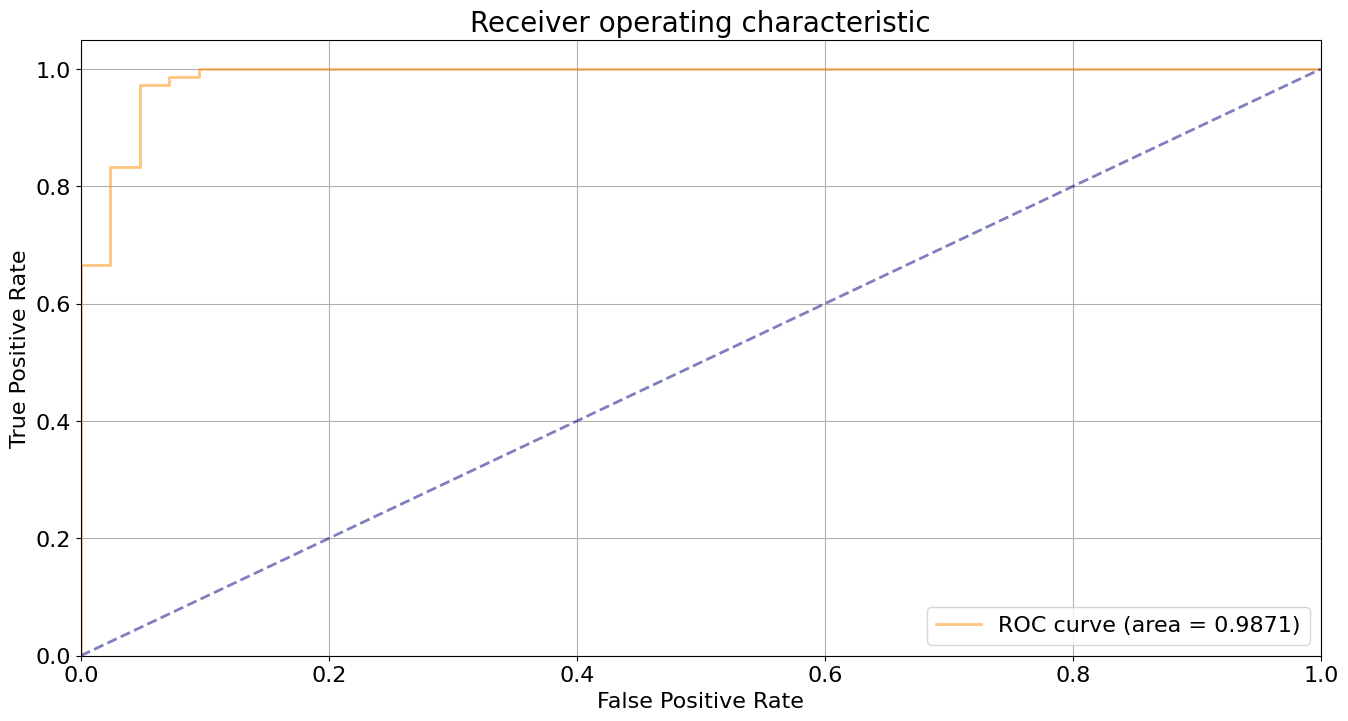

In [44]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_validation, y_validation)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [45]:
{k: v[-1] for k, v in model_metrics.items()}

{'Precision': 0.9889196675900277,
 'Recall': 1.0,
 'AUC': 0.9980577136514983,
 'PRAUC': 0.9986808236059574}

C:\Users\ralph\AppData\Local\Temp\ipykernel_17036\513595569.py:5: RuntimeWarning: invalid value encountered in divide
  precision = tpr/(tpr + fpr)


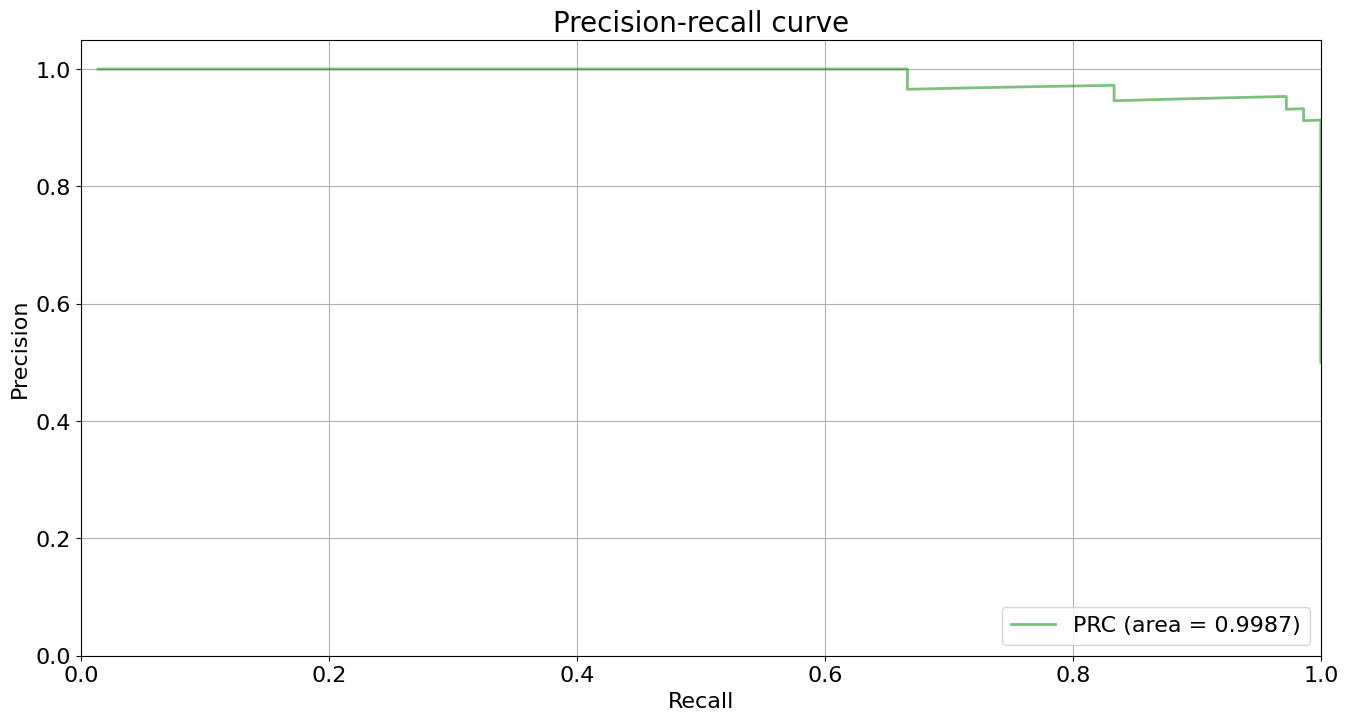

In [46]:
from catboost.utils import get_fnr_curve

(thresholds, fnr) = get_fnr_curve(model, eval_pool)

precision = tpr/(tpr + fpr)
recall = tpr/(tpr + fnr)

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(recall, precision, color='green',
         lw=lw, label='PRC (area = %0.4f)' % model_metrics['PRAUC'][-1], alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Precision-recall curve', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()